In [85]:
import psycopg2
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from adjustText import adjust_text
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
connection = psycopg2.connect(user="postgres", password="postgres", host="127.0.0.1", port="63333", database="stack_overflow")

In [3]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select country, count(*) as total
        from users u
        group by country""")
        u_countries_df = pd.DataFrame(cursor.fetchall(), columns=["country", "users"])

In [4]:
p_countries_df = pd.read_csv("../preprocessing/countryInfo.txt", delimiter="\t", usecols=["Country", "Population"])

In [5]:
countries_df = u_countries_df.join(p_countries_df.set_index('Country'), on="country").dropna()
countries_df.sort_values(by=["Population"], ascending=False).head()

,country,users,Population
104,China,107956,1.411779e+09
241,India,715071,1.352617e+09
613,United States,573934,3.271674e+08
246,Indonesia,62802,2.676634e+08
417,Pakistan,80769,2.122150e+08


In [26]:
countries_df[countries_df["Population"] == 0]

,country,users,Population
619,United States Minor Outlying Islands,2,0.0


In [27]:
countries_df = countries_df[countries_df["Population"] != 0]

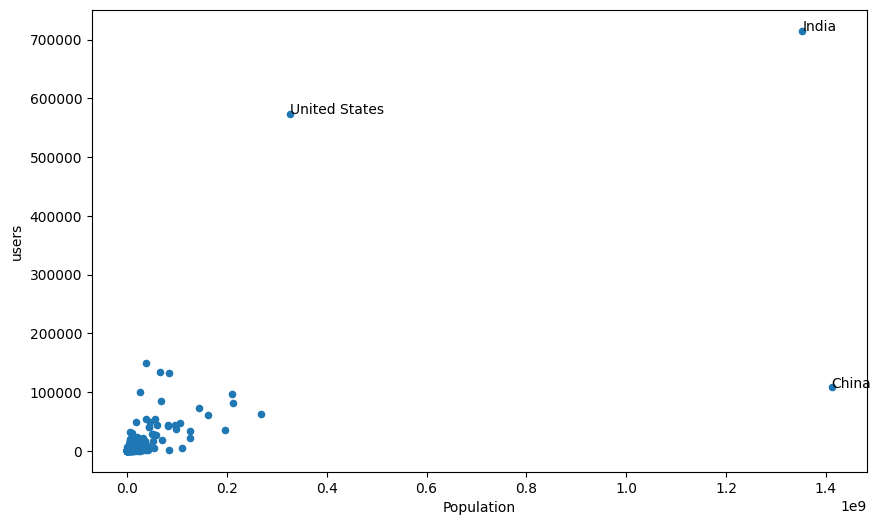

In [28]:
countries_df.plot(x="Population", y="users", kind="scatter")


for label, x, y in zip(countries_df[countries_df["Population"]>3e8]["country"],
                       countries_df[countries_df["Population"]>3e8]["Population"],
                       countries_df[countries_df["Population"]>3e8]["users"]):
    plt.annotate(label, xy=(x, y));

<Axes: xlabel='Population', ylabel='users'>

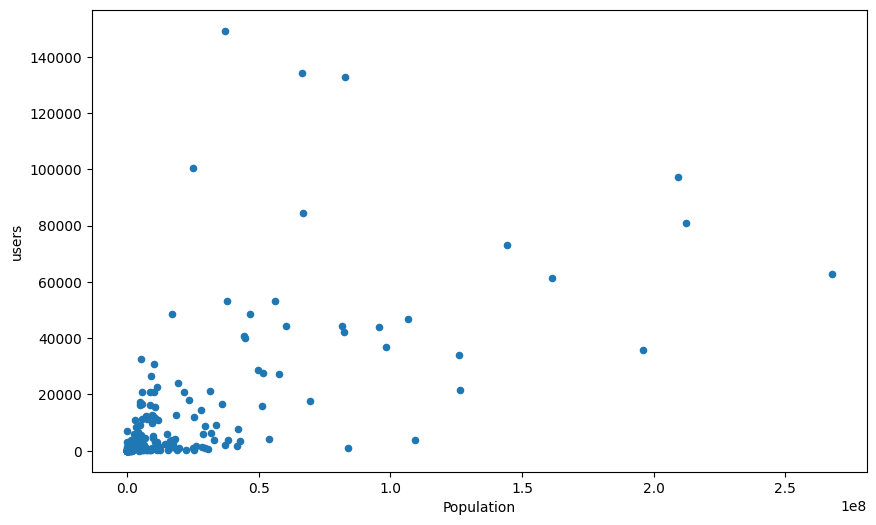

In [29]:
countries_df[countries_df["Population"]< 3e8].plot(x="Population", y="users", kind="scatter")

<Axes: xlabel='Population', ylabel='users'>

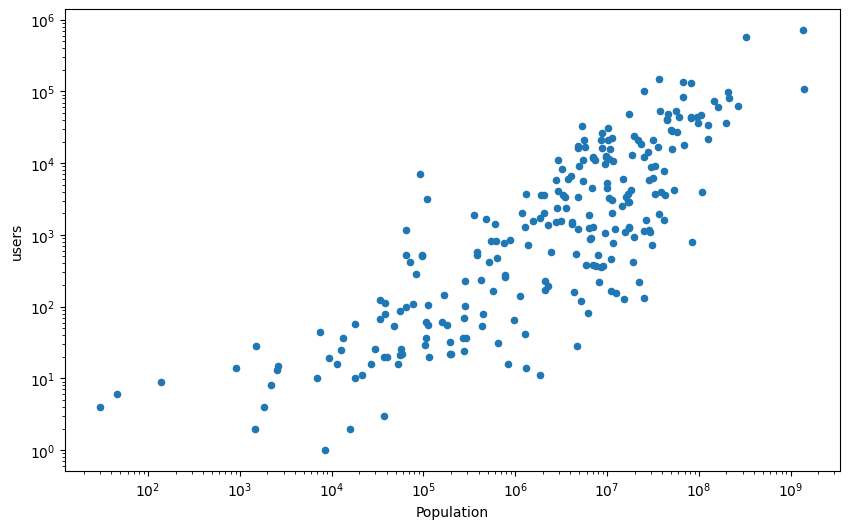

In [30]:
countries_df.plot(x="Population", y="users", kind="scatter", loglog=True)

In [50]:
model = sm.OLS(countries_df["users"], countries_df["Population"])
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  users   R-squared (uncentered):                   0.505
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                              247.8
Date:                Sun, 26 Mar 2023   Prob (F-statistic):                    5.74e-39
Time:                        20:02:24   Log-Likelihood:                         -2960.6
No. Observations:                 244   AIC:                                      5923.
Df Residuals:                     243   BIC:                                      5927.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

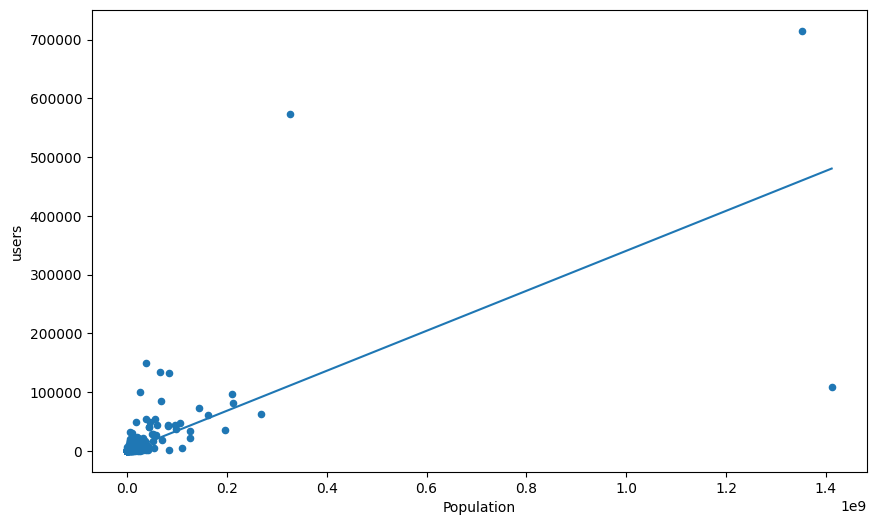

In [51]:
countries_df.plot(x="Population", y="users", kind="scatter")
max_pop = countries_df["Population"].max()
plt.plot([0,max_pop],[0, max_pop*results.params["Population"]]);

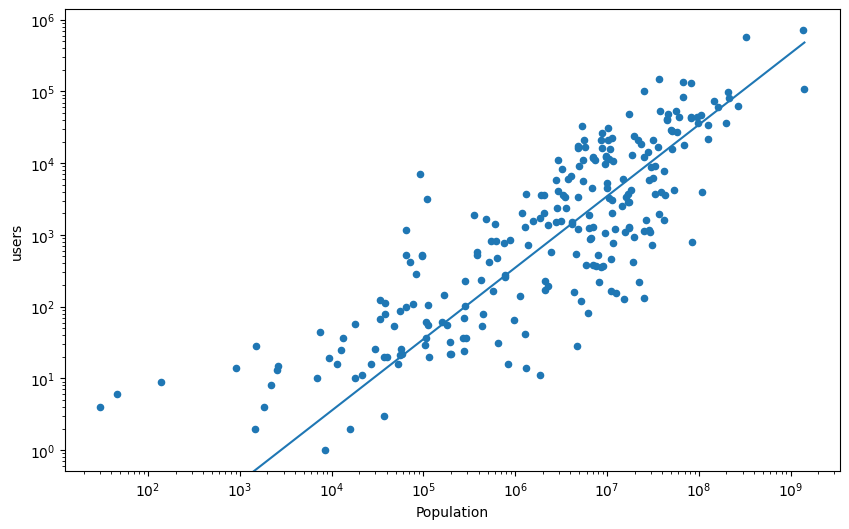

In [60]:
ax = countries_df.plot(x="Population", y="users", kind="scatter")
max_pop = countries_df["Population"].max()
plt.plot([0,max_pop],[0, max_pop*results.params["Population"]])

ax.set_yscale('log')
ax.set_xscale('log')

In [56]:
countries_df["error"] = countries_df["Population"]*results.params["Population"]-countries_df["users"]

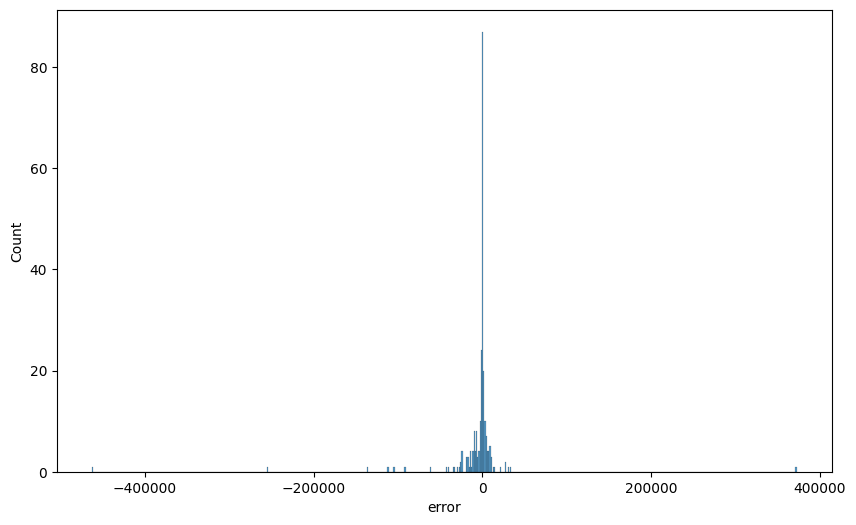

In [57]:
sns.histplot(data=countries_df, x="error");

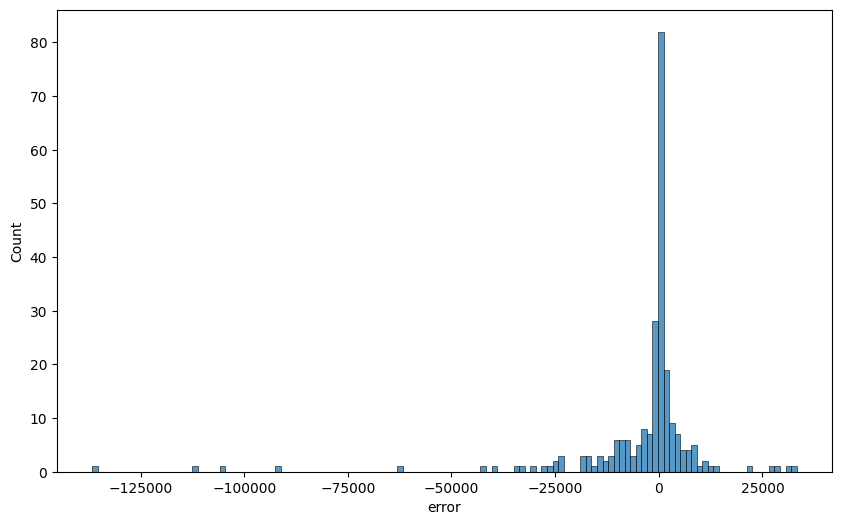

In [58]:
sns.histplot(data=countries_df[countries_df["Population"]< 3e8], x="error");

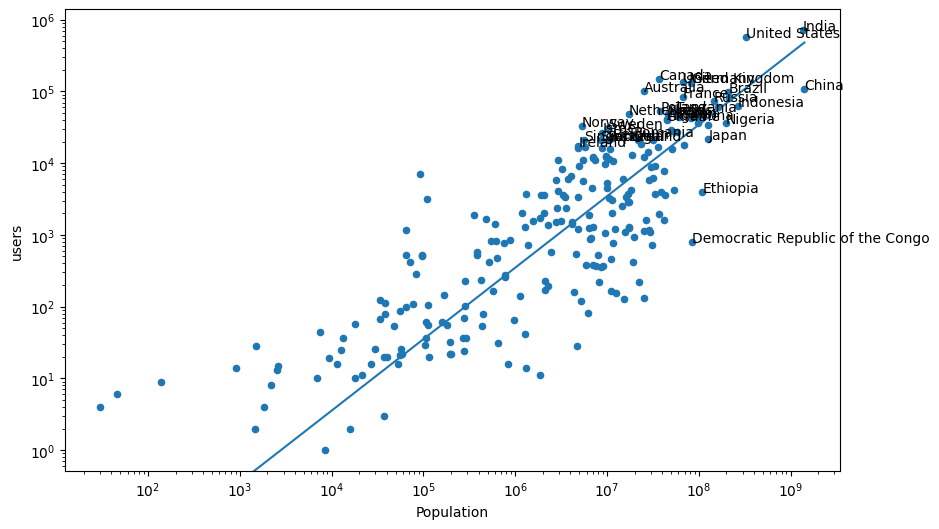

In [73]:
error_ts = 15000
ax = countries_df.plot(x="Population", y="users", kind="scatter")
max_pop = countries_df["Population"].max()
plt.plot([0,max_pop],[0, max_pop*results.params["Population"]])
ax.set_yscale('log')
ax.set_xscale('log')

filtered_df =  countries_df[np.abs(countries_df["error"]) > error_ts]
for label, x, y in zip(filtered_df["country"],
                       filtered_df["Population"],
                       filtered_df["users"]):
    plt.annotate(label, xy=(x, y));

In [75]:
countries_df["abs_log_error"] = np.abs(np.log(countries_df["Population"]*results.params["Population"])-np.log(countries_df["users"]))

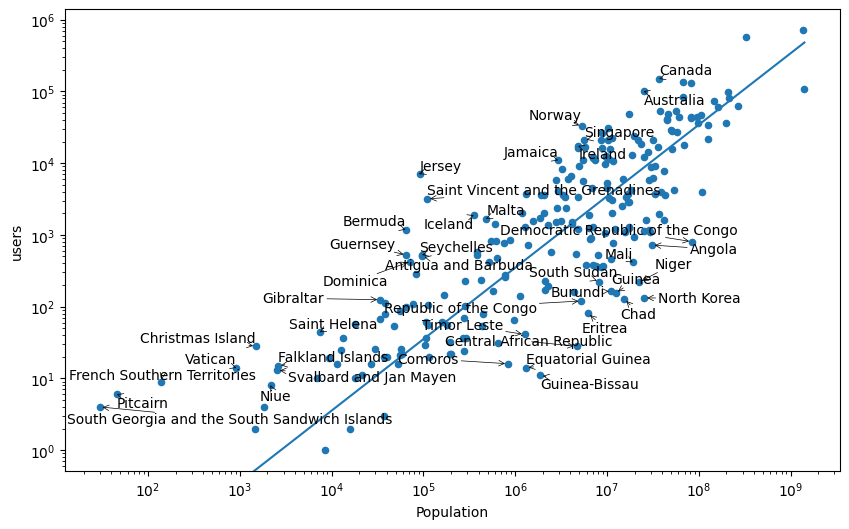

In [90]:
error_ts = 2.3
ax = countries_df.plot(x="Population", y="users", kind="scatter")
max_pop = countries_df["Population"].max()
plt.plot([0,max_pop],[0, max_pop*results.params["Population"]])
ax.set_yscale('log')
ax.set_xscale('log')

filtered_df =  countries_df[countries_df["abs_log_error"] > error_ts]
texts=[]
for label, x, y in zip(filtered_df["country"],
                       filtered_df["Population"],
                       filtered_df["users"]):
    texts.append(plt.text(x, y, label))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='black', lw=0.5));